# Восстановление золота из руды

<span style="color:green">
Подготовить прототип модели машинного обучения для компании, разрабатывающей решения для эффективной работы промышленных предприятий.

Когда добытая руда проходит первичную обработку, получается дроблёная смесь. Её отправляют на флотацию (обогащение) и двухэтапную очистку.

1. Флотация<br>
Во флотационную установку подаётся смесь золотосодержащей руды. После обогащения получается черновой концентрат и «отвальные хвосты», то есть остатки продукта с низкой концентрацией ценных металлов.
На стабильность этого процесса влияет непостоянное и неоптимальное физико-химическое состояние флотационной пульпы (смеси твёрдых частиц и жидкости).<br><br>
2. Очистка<br>
Черновой концентрат проходит две очистки. На выходе получается финальный концентрат и новые отвальные хвосты.

Для решения задачи вводится новая метрика качества — sMAPE (англ. Symmetric Mean Absolute Percentage Error, «симметричное среднее абсолютное процентное отклонение»).

Модель должна предсказать коэффициент восстановления золота из золотосодержащей руды.
Модель поможет оптимизировать производство, чтобы не запускать предприятие с убыточными характеристиками.

Необходимо:

1. Подготовить данные;
2. Провести исследовательский анализ данных;
3. Построить и обучить модель.
</span>

## Подготовка данных

<span style="color:green">
Подключим необходимые для работы модули
</span>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import RandomState

from scipy import stats as st
from sklearn.metrics import mean_absolute_error, make_scorer

from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.dummy import DummyRegressor

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

<span style="color:green">
Загрузим данные
</span>

In [2]:
train_data = pd.read_csv('gold_recovery_train_new.csv')
test_data = pd.read_csv('gold_recovery_test_new.csv')
full_data = pd.read_csv('gold_recovery_full_new.csv')

<span style="color:green">
Предварительный осмотр содержимого датафреймов
</span>

In [3]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14149 entries, 0 to 14148
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                14149 non-null  object 
 1   final.output.concentrate_ag                         14148 non-null  float64
 2   final.output.concentrate_pb                         14148 non-null  float64
 3   final.output.concentrate_sol                        13938 non-null  float64
 4   final.output.concentrate_au                         14149 non-null  float64
 5   final.output.recovery                               14149 non-null  float64
 6   final.output.tail_ag                                14149 non-null  float64
 7   final.output.tail_pb                                14049 non-null  float64
 8   final.output.tail_sol                               14144 non-null  float64


In [4]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5290 entries, 0 to 5289
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5290 non-null   object 
 1   primary_cleaner.input.sulfate               5286 non-null   float64
 2   primary_cleaner.input.depressant            5285 non-null   float64
 3   primary_cleaner.input.feed_size             5290 non-null   float64
 4   primary_cleaner.input.xanthate              5286 non-null   float64
 5   primary_cleaner.state.floatbank8_a_air      5290 non-null   float64
 6   primary_cleaner.state.floatbank8_a_level    5290 non-null   float64
 7   primary_cleaner.state.floatbank8_b_air      5290 non-null   float64
 8   primary_cleaner.state.floatbank8_b_level    5290 non-null   float64
 9   primary_cleaner.state.floatbank8_c_air      5290 non-null   float64
 10  primary_clea

In [5]:
full_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19439 entries, 0 to 19438
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                19439 non-null  object 
 1   final.output.concentrate_ag                         19438 non-null  float64
 2   final.output.concentrate_pb                         19438 non-null  float64
 3   final.output.concentrate_sol                        19228 non-null  float64
 4   final.output.concentrate_au                         19439 non-null  float64
 5   final.output.recovery                               19439 non-null  float64
 6   final.output.tail_ag                                19438 non-null  float64
 7   final.output.tail_pb                                19338 non-null  float64
 8   final.output.tail_sol                               19433 non-null  float64


<span style="color:green">
Итак, видим что у полного и учебного датасетов число столбцов и типы данных в них совпадают. У тестового датасета число столбцов меньше, причем, нет столбцов, отвечающих за финальный результат процесса обогащения руды, а на этапе вторичной очистки стот данные, определяющие характеристики агрегатов очистики, нежели параметры, связанные непосредственно с металлическими рудами
</span>

<span style="color:green">
Проверим, что эффективность обогащения рассчитана правильно. Вычислим ее на обучающей выборке для признака rougher.output.recovery. Найдем MAE, между проеведнными расчетами и результатом, приведенным в таблице
</span>

<span style="color:green">
Итак, оценим эффективность чернового обогащения именно золота в руде
</span>

In [6]:
# Функция для расчета эффективности обогащения

def eval_recovery_effectiveness(element):
    if pd.isnull(element[1]) or pd.isnull(element[2]) or pd.isnull(element[3]):
        return 

    C = element[2]
    F = element[1]
    T = element[3]
    return (C * (F - T)) / (F * (C - T)) * 100.0

def eval_recovery_effectiveness_2(dataframe):
    C = dataframe['rougher.output.concentrate_au']
    F = dataframe['rougher.input.feed_au']
    T = dataframe['rougher.output.tail_au']

    result = (C * (F - T)) / (F * (C - T)) * 100.0
    return result

sub_columns = ['rougher.output.recovery', 'rougher.input.feed_au', 'rougher.output.concentrate_au', 'rougher.output.tail_au']
sub_rough_data = train_data[sub_columns]
sub_rough_data = sub_rough_data.dropna()
sub_rough_data.reset_index(drop=True, inplace=True)
recovery_check = eval_recovery_effectiveness_2(sub_rough_data)
mae_full = mean_absolute_error(sub_rough_data['rougher.output.recovery'], recovery_check)
print(f'MAE_full: {mae_full}')

MAE_full: 9.73512347450521e-15


<span style="color:green">
Проанализируйте признаки, недоступные в тестовой выборке
</span>

<span style="color:green">
Итак:<br><br>
- в классе primary есть только вход по катализаторам и работе емкости, но ничего нет по сырью<br>
- класса final нет<br>
- в классе rougher нет ничего по выходу сырья (пустая порода и полезная обогащенная порода)<br>
- в классе secondary нет ничего по выходу пустой породы<br><br>
</span>

<span style="color:green">
Раз получается, что в тренировочной выборке указаны параметры, которые известны сразу, а в тестовой те - которые становятся изветсны после проведения очистки, составим учебную и тестовую выборки, с тем, чтобы они работали только с априорными данными процесса очистки
</span>

In [7]:
work_columns = list(test_data.columns)
include_spec = work_columns
work_columns.append('rougher.output.recovery')
work_columns.append('final.output.recovery')

train_data = train_data[work_columns]

# К тестовым данным приаттачим 'rougher.output.recovery' и 'final.output.recovery' из full_data, согласно признаку 'date'
not_full_data = full_data[['date', 'rougher.output.recovery', 'final.output.recovery']]
left_a = test_data.set_index('date')
right_a = not_full_data.set_index('date')

test_data = left_a.reindex(columns=left_a.columns.union(right_a.columns))
test_data.update(right_a)
test_data.reset_index(inplace=True)

## Анализ данных

<span style="color:green">
Посмотрим, как меняется концентрация металлов (Au, Ag, Pb) на различных этапах очистки
</span>


<span style="color:green">
Создадим визуализацию того, как менялась концентрация металлов
</span>

In [8]:
dct = {'Золото':'au', 'Серебро':'ag', 'Свинец':'pb'}

def get_metal_conc_data(metal_prefix):
    col_0 = 'rougher.input.feed_' + metal_prefix
    col_1 = 'rougher.output.concentrate_' + metal_prefix
    col_2 = 'primary_cleaner.output.concentrate_' + metal_prefix
    col_3 = 'final.output.concentrate_' + metal_prefix
    concentration = full_data[[col_0, col_1, col_2, col_3]]
    
    return concentration

def concentration_change_scatter(metal_prefix):
    concentration = get_metal_conc_data(metal_prefix)
    zeros_array = np.zeros(shape=(len(concentration),))
    ones_array = np.ones(shape=(len(concentration),))
    twos_array = np.ones(shape=(len(concentration),))*2
    threes_array = np.ones(shape=(len(concentration),))*3
    dat = pd.concat([concentration.iloc[:,0], concentration.iloc[:,1], concentration.iloc[:,2], concentration.iloc[:,3]], ignore_index=True)
    plt.figure(figsize=(13,6))
    plt.scatter(np.concatenate((zeros_array, ones_array, twos_array, threes_array)), dat, alpha=0.01);
    plt.xlabel('Номер этапа')
    plt.ylabel('Концентрация в %')
    plt.title('Изменение концентрации металла по этапам')

def concentration_change_hist(metal_prefix):
    concentration = get_metal_conc_data(metal_prefix)
    
    plt.figure(figsize=(13,6))
    concentration.iloc[:,0].hist(bins=20, alpha=0.7); # В общем, тут вообще все нужно в один график запихнуть и оставить только легенду для разных цветов гистограмм
    concentration.iloc[:,1].hist(bins=20, alpha=0.7);
    concentration.iloc[:,2].hist(bins=20, alpha=0.7);
    concentration.iloc[:,3].hist(bins=20, alpha=0.7);
    plt.legend(['Концентрация до флотации', 'Концентрация после флотации', 'Концентрация после первого этапа', 'Концентрация после второго этапа'])
    plt.xlabel('Концентрация в %')
    plt.ylabel('Число образов')

<span style="color:green">
Посмторим на изменение концентрации золота
</span>

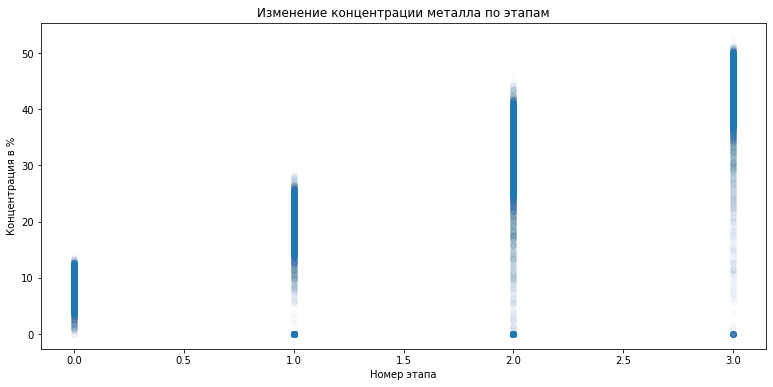

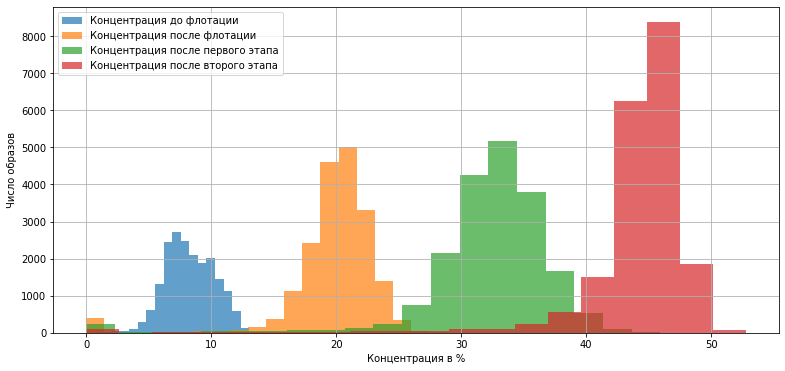

In [9]:
concentration_change_scatter(dct['Золото'])
concentration_change_hist(dct['Золото'])

<span style="color:green">
На графиках очевиден тренд на увеличение концентрации золота начиная от сырой руды, и заканчивая выходом из обогатительного процесса
</span>

<span style="color:green">
Посмторим на изменение концентрации серебра
</span>

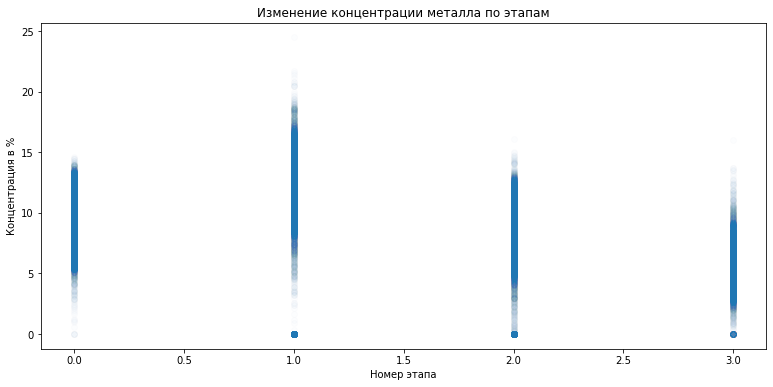

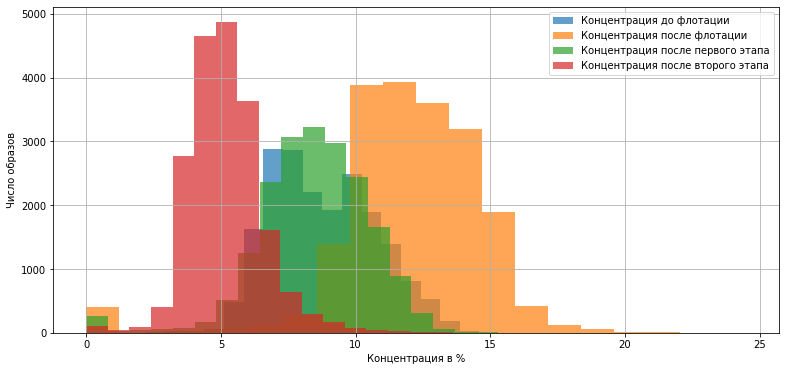

In [10]:
concentration_change_scatter(dct['Серебро'])
concentration_change_hist(dct['Серебро'])

<span style="color:green">
Выходная концентрация серебра падает. С одной стороны - получается, что это то, что нужно, так как идет выделение золотоа. С другой стороны, лучше бы так падала концентрация свинца, нежели серебра
</span>

<span style="color:green">
Посмторим на изменение концентрации свинца
</span>

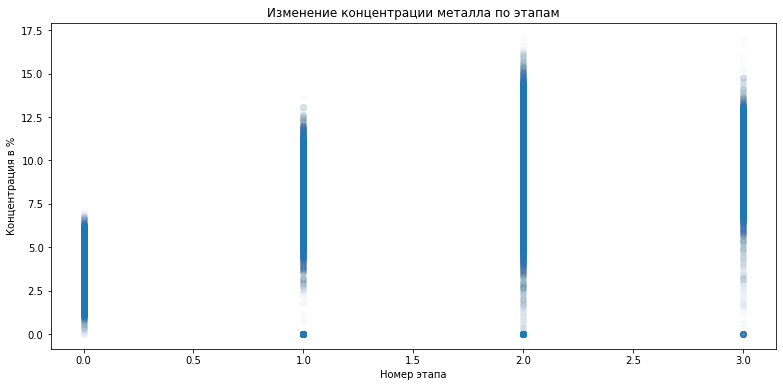

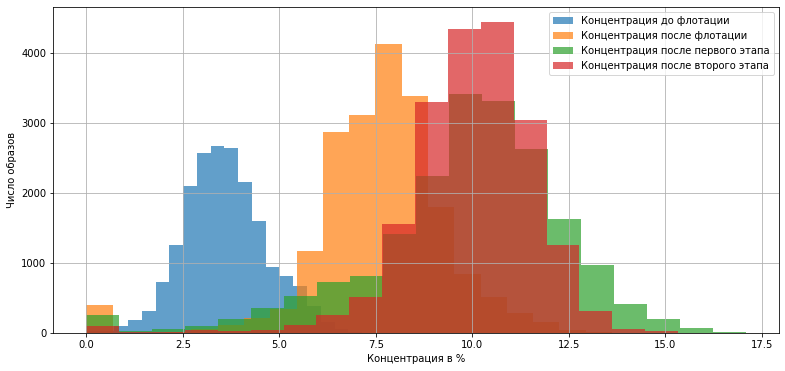

In [11]:
concentration_change_scatter(dct['Свинец'])
concentration_change_hist(dct['Свинец'])

<span style="color:green">
У свинца наблюдается тренд к увеличению концентрации в руде в ходе очистки, однако после флотации рост концентрации довольно мал
</span>

<span style="color:green">
Выводы:<br>
После первичной и вторичной фильтрации, концентрация свинца не увеличивается, но все равно остается достаточно высокой - 10%. Лучше бы оставалось столько серебра
</span>

<span style="color:green">
Сравним распределения размеров гранул сырья на обучающей и тестовой выборках
</span>

<span style="color:green">
Создадим визуализацию того, как выглядит распределение размеров гранул сырья на обучающей и тестовой выборках
</span>

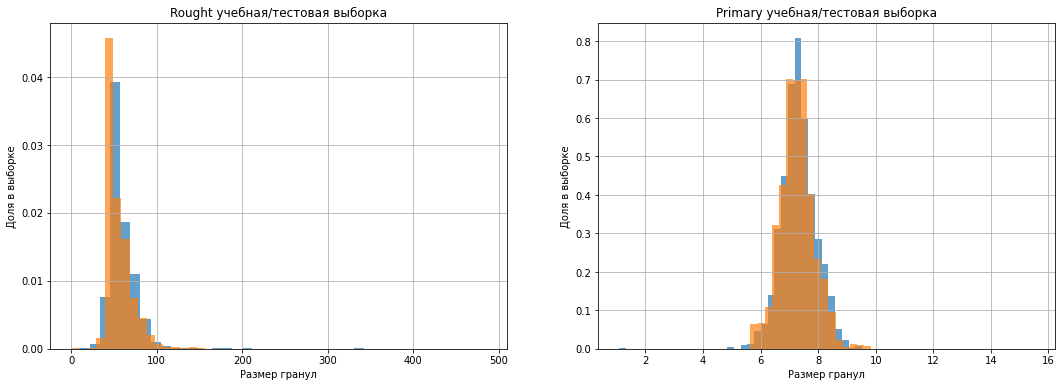

In [12]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18,6))

train_feed_size_rought = train_data['rougher.input.feed_size']
train_feed_size_primary = train_data['primary_cleaner.input.feed_size']

test_feed_size_rought = test_data['rougher.input.feed_size']
test_feed_size_primary = test_data['primary_cleaner.input.feed_size']

ax_0 = train_feed_size_rought.hist(bins=40, density=True, alpha=0.7, ax=ax[0]);
ax_0 = test_feed_size_rought.hist(bins=40, density=True, alpha=0.7, ax=ax[0]);
ax_1 = train_feed_size_primary.hist(bins=40, density=True, alpha=0.7, ax=ax[1]);
ax_1 = test_feed_size_primary.hist(bins=40, density=True, alpha=0.7, ax=ax[1]);

ax_0.set_xlabel('Размер гранул')
ax_0.set_ylabel('Доля в выборке')
ax_0.title.set_text('Rought учебная/тестовая выборка')

ax_1.set_xlabel('Размер гранул')
ax_1.set_ylabel('Доля в выборке')
ax_1.title.set_text('Primary учебная/тестовая выборка')

<span style="color:green">
В целом, гистограммы учебной и тестовой выборок довольно похожи, поэтому можно использовать train и test датасеты для обучения
</span>

<span style="color:green">
Создадим визуализацию того, как выглядит суммарная концентрация всех веществ на разных стадиях очистки
</span>

Rought - mean: 21.13889230678671,  interval: (21.071939113272805, 21.20584550030061)
Primary - mean: 39.69019202965643,  interval: (39.58757343478669, 39.79281062452617)
Final - mean: 59.49600654988581,  interval: (59.421387609751456, 59.57062549002017)


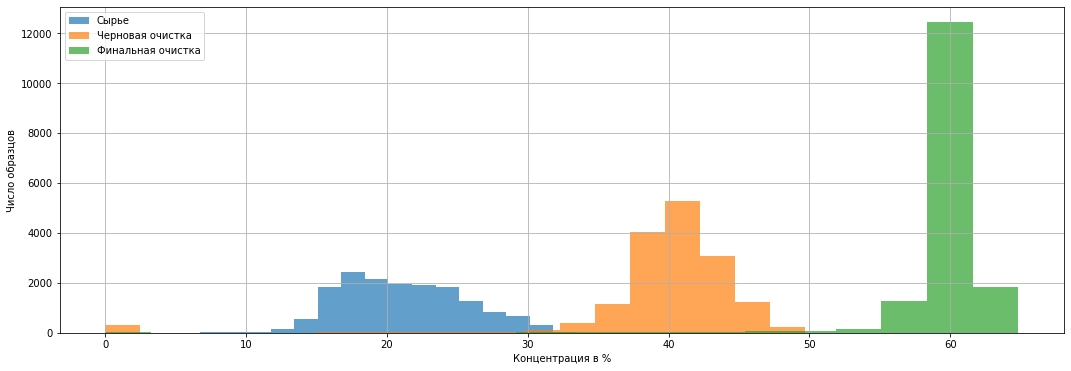

In [13]:
names = ['Rought', 'Primary', 'Final']
clear_full_data = full_data.dropna()

sum_concentration = []
sum_concentration.append(clear_full_data['rougher.input.feed_ag'] + clear_full_data['rougher.input.feed_au'] + clear_full_data['rougher.input.feed_pb'])
sum_concentration.append(clear_full_data['rougher.output.concentrate_ag'] + clear_full_data['rougher.output.concentrate_au'] + clear_full_data['rougher.output.concentrate_pb'])
sum_concentration.append(clear_full_data['final.output.concentrate_ag'] + clear_full_data['final.output.concentrate_au'] + clear_full_data['final.output.concentrate_pb'])

#fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(18,6))

plt.figure(figsize=(18,6))
sum_concentration[0].hist(bins=20, alpha=0.7)
sum_concentration[1].hist(bins=20, alpha=0.7)
sum_concentration[2].hist(bins=20, alpha=0.7)
plt.xlabel('Концентрация в %')
plt.ylabel('Число образцов')


# Найдем среднее и доверительные интервалы для каждой выборки
for i in range(3):
    cons_rough_mean = sum_concentration[i].mean()
    rough_conf_interval = st.t.interval(alpha=0.95, df=len(sum_concentration[i])-1, loc=cons_rough_mean, scale=st.sem(sum_concentration[i]))
    print(f'{names[i]} - mean: {cons_rough_mean},  interval: {rough_conf_interval}')

plt.legend(['Сырье', 'Черновая очистка', 'Финальная очистка'])

<span style="color:green">
Для суммарной концетрации, тем не менее, можно видеть, что она растет в процессе очистки руды, доходя до почти 60% средней концентрации, причем вместе с ростом средней концентрации идет уменьшение дисперсии величины концентрации
</span>

## Модель

<span style="color:green">
Напишем функцию для вычисления итоговой sMAPE
</span>

In [14]:
def get_smape(data_1, data_2, **kwargs):
    if len(data_1) != len(data_2):
        return np.nan
    
    up = np.abs(data_1 - data_2)
    down = (np.abs(data_1) + np.abs(data_2))/2.0
    up_n_down = up/down
    return 100.0 * np.mean(up_n_down)

def get_smape_model(model, X, y):
    y_pred = model.predict(X)
    y_true = y
    return get_smape(y_true, y_pred)

smape_scores = make_scorer(get_smape, greater_is_better=False)

<span style="color:green">
Для начала, заполним все пропущенные значения в full_data, за исключением 'rougher.output.recovery' и 'final.output.recovery' с помощью метода ffill, поскольку все данные в таблице уже отсортироаны по времени (ниже докажем это)
</span>

In [15]:
# Покажем, что все времена в исходной таблице стоят в порядке возрастания
sub_date = full_data['date']
sub_date = pd.to_datetime(sub_date)
check = True
for i in range(len(sub_date)-1):
    if sub_date[i] > sub_date[i+1]:
        check = False
print(f'Sorted: {check}')

Sorted: True


In [16]:
# Заполним данные
full_data[include_spec] = full_data[include_spec].fillna(method='ffill')

In [17]:
ind_au_1 = set(full_data[full_data['rougher.input.feed_au'] == 0]['date'])
ind_au_2 = set(full_data[full_data['rougher.output.concentrate_au'] == 0]['date'])
ind_au_3 = set(full_data[full_data['primary_cleaner.output.concentrate_au'] == 0]['date'])
ind_au_4 = set(full_data[full_data['final.output.concentrate_au'] == 0]['date'])
ind_au = ind_au_1.union(ind_au_2.union(ind_au_3.union(ind_au_4)))

ind_ag_1 = set(full_data[full_data['rougher.input.feed_ag'] == 0]['date'])
ind_ag_2 = set(full_data[full_data['rougher.output.concentrate_ag'] == 0]['date'])
ind_ag_3 = set(full_data[full_data['primary_cleaner.output.concentrate_ag'] == 0]['date'])
ind_ag_4 = set(full_data[full_data['final.output.concentrate_ag'] == 0]['date'])
ind_ag = ind_ag_1.union(ind_ag_2.union(ind_ag_3.union(ind_ag_4)))

ind_pb_1 = set(full_data[full_data['rougher.input.feed_pb'] == 0]['date'])
ind_pb_2 = set(full_data[full_data['rougher.output.concentrate_pb'] == 0]['date'])
ind_pb_3 = set(full_data[full_data['primary_cleaner.output.concentrate_pb'] == 0]['date'])
ind_pb_4 = set(full_data[full_data['final.output.concentrate_pb'] == 0]['date'])
ind_pb = ind_pb_1.union(ind_pb_2.union(ind_pb_3.union(ind_pb_4)))

inds = ind_au.union(ind_ag.union(ind_pb))
print(len(inds))

# Заполним NaNs в train_data
not_full_data = full_data[include_spec]
left_a = train_data.set_index('date')
right_a = not_full_data.set_index('date')

train_data = left_a.reindex(columns=left_a.columns.union(right_a.columns))
train_data.update(right_a)
train_data.reset_index(inplace=True)

# Заполним NaNs в test_data
not_full_data = full_data[include_spec]
left_a = test_data.set_index('date')
right_a = not_full_data.set_index('date')

test_data = left_a.reindex(columns=left_a.columns.union(right_a.columns))
test_data.update(right_a)
test_data.reset_index(inplace=True)

# Удалим все строки для train и test, где концентрации металлов после очистки были равны нулю - это явно какая-то ошибка
train_data = train_data.query('date not in @inds')
test_data = test_data.query('date not in @inds')

591


In [18]:
# Даты нам теперь не нужны
train_data.drop('date', inplace=True, axis=1)
test_data.drop('date', inplace=True, axis=1)

<span style="color:green">
Обучим модели линейной регрессии, дерево регрессии, лес деревьев и наивный регрессионный алгоритм для параметров 'rougher.output.recovery' и 'final.output.recovery'
</span>

<span style="color:green">
Сначала поставим признаки учебной и тестовой выборок в одинаковый порядок
</span>

In [19]:
cols = test_data.columns
train_data = train_data[cols]

<span style="color:green">
Построим модели для предсказания 'rougher.output.recovery'
</span>

In [20]:
features_train = train_data.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_train = train_data['rougher.output.recovery']

features_test = test_data.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test = test_data['rougher.output.recovery']

In [21]:
# Линейная регрессия

lr_model_rougher = LinearRegression()
lr_model_rougher.fit(features_train, target_train)
lr_rougher_scores = cross_val_score(lr_model_rougher, features_train, target_train, scoring=smape_scores, cv=5)
print(f'Linear regression cross-validation {-lr_rougher_scores}, mean of cross_validation {np.mean(-lr_rougher_scores)}')

Linear regression cross-validation [9.64639848 7.20258456 5.57674694 4.86839332 9.03435694], mean of cross_validation 7.265696047566005


In [22]:
# Дерево регрессии

state = RandomState(123)
param_grid = {'max_depth': range(1,25), 'min_samples_split': range(2,5), 'min_samples_leaf': range(1,4)}
tree_model_rougher = DecisionTreeRegressor(random_state=state)
grid_search = GridSearchCV(tree_model_rougher, param_grid, cv=5, scoring=smape_scores)
grid_search.fit(features_train, target_train)
tree_rougher_params = grid_search.best_params_
tree_rougher_smape = grid_search.best_score_
print(f'Decision Tree best params: {tree_rougher_params}')
print(f'Decision Tree best sMAPE: {-tree_rougher_smape}')

Decision Tree best params: {'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2}
Decision Tree best sMAPE: 7.278338557867324


In [23]:
# Лес деревьев

param_grid = {'n_estimators': range(10,51,10), 'max_depth': range(1,11)}
forest_model_rougher = RandomForestRegressor(random_state=state)
grid_search = GridSearchCV(forest_model_rougher, param_grid, cv=5, scoring=smape_scores)
grid_search.fit(features_train, target_train)
forest_rougher_params = grid_search.best_params_
forest_rougher_smape = grid_search.best_score_
print(f'Random Forest best params: {forest_rougher_params}')
print(f'Random Forest best sMAPE: {-forest_rougher_smape}')

Random Forest best params: {'max_depth': 6, 'n_estimators': 10}
Random Forest best sMAPE: 6.5220379532697565


In [24]:
# Проверка алгоритмов

# Линейная регрессия
target_predicted = lr_model_rougher.predict(features_test)
lr_rougher_smape = get_smape(target_test, target_predicted)
print(f'Linear regression sMAPE: {lr_rougher_smape}')

# Дерево регрессии
best_tree_rougher = DecisionTreeRegressor(random_state=state, max_depth=tree_rougher_params['max_depth'], min_samples_split=tree_rougher_params['min_samples_split'], min_samples_leaf=tree_rougher_params['min_samples_leaf'])
best_tree_rougher.fit(features_train, target_train)
target_pred = best_tree_rougher.predict(features_test)
tree_rougher_smape = get_smape(target_test, target_pred)
print(f'Best Tree sMAPE: {tree_rougher_smape}')

# Лес деревьев
best_forest_rougher = RandomForestRegressor(random_state=state, max_depth=forest_rougher_params['max_depth'], n_estimators=forest_rougher_params['n_estimators'])
best_forest_rougher.fit(features_train, target_train)
target_pred = best_forest_rougher.predict(features_test)
forest_rougher_smape = get_smape(target_test, target_pred)
print(f'Best Forest sMAPE: {forest_rougher_smape}')

# Наивный алгоритм регрессии
dummy_rougher = DummyRegressor(strategy='mean')
dummy_rougher.fit(features_train, target_train)
dummy_predict = dummy_rougher.predict(features_test)
dummy_rougher_smape = get_smape(target_test, dummy_predict)
print(f'Dummy regressor sMAPE: {dummy_rougher_smape}')

Linear regression sMAPE: 4.8674530942613545
Best Tree sMAPE: 5.215346412498076
Best Forest sMAPE: 4.629052165170159
Dummy regressor sMAPE: 5.364780952068203


<span style="color:green">
Для 'rougher.output.recovery' лучше всего справился случайный лес
</span>

<span style="color:green">
Теперь построим модели для предсказания 'final.output.recovery'
</span>

In [25]:
features_train = train_data.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_train = train_data['final.output.recovery']

features_test = test_data.drop(['rougher.output.recovery','final.output.recovery'], axis=1)
target_test = test_data['final.output.recovery']

In [26]:
# Линейная регрессия

lr_model_final = LinearRegression()
lr_model_final.fit(features_train, target_train)
lr_final_scores = cross_val_score(lr_model_final, features_train, target_train, scoring=smape_scores, cv=5)
print(f'Linear regression cross-validation {-lr_final_scores}, mean of cross_validation {np.mean(-lr_final_scores)}')

Linear regression cross-validation [13.40101442  9.72494889  9.26519869  9.08363603 13.27786447], mean of cross_validation 10.950532500993202


In [27]:
# Дерево регрессии

param_grid = {'max_depth': range(1,25), 'min_samples_split': range(2,5), 'min_samples_leaf': range(1,4)}
tree_model_final = DecisionTreeRegressor(random_state=state)
grid_search = GridSearchCV(tree_model_final, param_grid, cv=5, scoring=smape_scores)
grid_search.fit(features_train, target_train)
tree_final_params = grid_search.best_params_
tree_final_smape = grid_search.best_score_
print(f'Decision Tree best params: {tree_final_params}')
print(f'Decision Tree best sMAPE: {-tree_final_smape}')

Decision Tree best params: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}
Decision Tree best sMAPE: 9.440354196471505


In [28]:
# Лес деревьев

param_grid = {'n_estimators': range(10,51,10), 'max_depth': range(1,11)}
forest_model_final = RandomForestRegressor(random_state=state)
grid_search = GridSearchCV(forest_model_final, param_grid, cv=5, scoring=smape_scores)
grid_search.fit(features_train, target_train)
forest_final_params = grid_search.best_params_
forest_final_smape = grid_search.best_score_
print(f'Random Forest best params: {forest_final_params}')
print(f'Random Forest best sMAPE: {-forest_final_smape}')

Random Forest best params: {'max_depth': 4, 'n_estimators': 10}
Random Forest best sMAPE: 9.040874138047588


In [31]:
forest_1_smape = 6.5220379532697565
forest_2_smape = 9.040874138047588

# Проверка алгоритмов

# Линейная регрессия
target_predicted = lr_model_final.predict(features_test)
lr_final_smape = get_smape(target_test, target_predicted)
print(f'Linear regression sMAPE: {lr_final_smape}')

# Дерево регрессии
best_tree_final = DecisionTreeRegressor(random_state=state, max_depth=tree_final_params['max_depth'], min_samples_split=tree_final_params['min_samples_split'], min_samples_leaf=tree_final_params['min_samples_leaf'])
best_tree_final.fit(features_train, target_train)
target_pred = best_tree_final.predict(features_test)
tree_final_smape = get_smape(target_test, target_pred)
print(f'Best Tree sMAPE: {tree_final_smape}')

# Лес деревьев
best_forest_final = RandomForestRegressor(random_state=state, max_depth=forest_final_params['max_depth'], n_estimators=forest_final_params['n_estimators'])
best_forest_final.fit(features_train, target_train)
target_pred = best_forest_final.predict(features_test)
forest_final_smape = get_smape(target_test, target_pred)
print(f'Best Forest sMAPE: {forest_final_smape}')

# Наивный алгоритм регрессии
dummy_final = DummyRegressor(strategy='mean')
dummy_final.fit(features_train, target_train)
dummy_predict = dummy_final.predict(features_test)
dummy_final_smape = get_smape(target_test, dummy_predict)
print(f'Dummy regressor sMAPE: {dummy_final_smape}')

Linear regression sMAPE: 8.13223189410281
Best Tree sMAPE: 8.41194122575755
Best Forest sMAPE: 8.175754593596231
Dummy regressor sMAPE: 8.582525522731439


<span style="color:green">
Проверяя наилучшие кросс-валидационные показатели sMAPE для признаков rougher.output.recovery и final.output.recovery, получаем, что наименьшие результаты симметричной средней абсолютной процентной ошибки получились у лесов деревьев, со значениями 6.522 и 9.041 соответственно.<br> При проверке этих лесов деревьев на тестовой выборке, значения sMAPE оказались равны 4.629 и 8.238. Эти оценки превзошли наивный регрессионный алгоритм в обоих случаях, для rougher.output.recovery лес деревьев также отработал лучше линейной регрессии и дерева регрессии. Для final.output.recovery на тестовой выборке лес деревьев ненамного превзошла модель линейной регрессии. Тем не менее, для расчета итогового значения sMAPE модели, мы используем полученные в ходе кросс-валидации результаты лесов деревьев
</span>

<span style="color:green">
Для расчета финального значения sMAPE мы берем значения sMAPE_rougher = 4.629052165170159 и sMAPE_final = 8.175754593596231 (это значения, которые нам дали леса деревьев на тестовой выборке) и получаем:
</span>

In [1]:
full_smape = 0.25*4.629052165170159 + 0.75*8.175754593596231
print(f'Full sMAPE: {full_smape}')

Full sMAPE: 7.289078986489713


<span style="color:green">
Выводы<br><br>
Была просмотрена технология обогащения золотосодержащих руд. В результате исследования изменения концентрации полезных металлов обогащаемой руды на разных этапах процесса, было установлено, что процесс лучше всего приспособлен для ощистки золота, чуть хуже - свинца и совершенно не подходит для очистки серебра<br>
Были построены предсказательные модели для предсказания концентрации золота в руде после этапа флоатации и в самом конце технологического процесса. Для оценки качества предсказания была предложена метрика cимметричной средней абсолютной процентной ошибки.
</span>

<span style="color:green">
По данным задачи были построены предсказательные модели нахождения эффективности очистки руды после флотации и в конце всего процесса, где, для обоих этапов, наилучшими моделями оказались леса регрессионных деревьев. Финальное значение sMAPE процесса очистки оказалось равным 7.29%
</span>